In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
from astropy.time import Time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

import numpy as np
import pandas as pd
import seaborn as sns

from photutils import RectangularAperture, RectangularAnnulus, aperture_photometry

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['axes.formatter.useoffset'] = False
%matplotlib inline

from pocs.utils import images
from pocs.utils.jupyter import widgets
from piaa import utils

#  Get Data

PIAA is run against an `observation`, which consists of a sequence of `images` for a given `field`. The `field`s are chosen by the PANOPTES network based on their stellar density, targets of interest, and sky coverage, amongst other factors. The default exposure time for each `image` is 120 seconds (regardlesss of conditions such as moon phase) and each `observation` consists of a minimum of two (2) hours of data, giving a total of at least 60 `image`s per `observation`. _(Note: The scheduler can choose to dwell on a field longer than the minimum amount of time, the details of which are not covered here.)_

Here we select an `observation` of the field containing the star `KIC 8462852` (Tabby's star) taken on 2016-09-11 from `PAN001` on Mauna Loa. This particular `observation` was taken before the scheduler details were refined so only consists of 46 total exposures intead of 60.

In [2]:
field_dir = '/var/panoptes/images/fields/Wasp35/14d3bd/20161122T085732/'
seq_files = glob("{}/2016*.fits".format(field_dir))
seq_files.sort()
print("Number of images: {}".format(len(seq_files)))

Number of images: 55


##### Point Sources

PANOPTES will define a catalog of stars of particular interest, with each entry in the catalog being referred to as a PANOPTES Input Catalog (PIC) star. Each PIC will be identified by a reference id and the catalog will also contain the J2000 RA/Dec of the PIC. These coordinates will be in used with a plate-solved world coordinate system (WCS) to identify the PIC within each `image` of the `observation`.

Because the PICs have not yet formally been defined by PANOPTES, here we use `sextractor` on the first image in the `observation` to identify point sources. This list is not comprehensive and should not be considered representative of the eventual point sources that will be used by PANOPTES.

No refinement of the `sextractor` parameters has been given, with all point sources not flagged by `sextractor` being used for the analysis in the rest of this document.

In [3]:
point_sources = utils.get_point_sources(field_dir, seq_files, force_new=True)
print("Number of point sources: {}".format(len(point_sources)))

Number of point sources: 26652


In [4]:
point_sources['color'] = [utils.pixel_color(int(row['X']), int(row['Y']), zero_based=False) for row in point_sources]

In [5]:
point_sources[0:10]

X,Y,ALPHAPEAK_J2000,DELTAPEAK_J2000,BACKGROUND,FLUX_AUTO,FLUX_MAX,FLUXERR_AUTO,FWHM_IMAGE,color
pix,pix,deg,deg,ct,ct,ct,ct,pix,
int64,int64,float64,float64,float64,float64,float64,float64,float64,str2
4670,5,82.2481412,-13.0194405,2089.799,409.0413,77.04004,99.78525,-0.1,B
586,6,81.9892479,-1.4080514,2089.181,335.6843,76.83887,85.09715,0.97,G1
2607,5,82.1171607,-7.1545279,2090.487,475.0881,62.61572,99.78525,0.51,G2
1850,7,82.064237,-4.9959713,2094.695,295.9082,77.33252,78.16672,0.88,B
4576,5,82.2420988,-12.7539515,2090.296,482.8523,61.76904,114.5655,2.67,B
4351,6,82.2247687,-12.1175939,2090.926,657.9253,64.02832,125.8604,4.71,R
513,7,81.9819607,-1.2019797,2088.081,505.8513,92.08716,98.64481,1.81,G2
3068,7,82.1403897,-8.4696283,2095.45,589.1714,117.3457,70.55882,4.53,B


In [6]:
background_flux = point_sources['BACKGROUND'].mean()
background_flux

2094.3897865450999

# Identify Reference PSFs

Reference PSFs are identifed via their morphological similarity with the target PSF across the entire `observation` according to the following process:

1. Flux normalized postage stamp cubes (PSC) are created for each point source, where the `x` and `y` of the cube correspond to the stamp size (see below) and the `z` component corresponds to the individual `image`s.
2. The sum-squared-difference (SSD) of the target stamp and a point source stamp is computed for each `image`.
3. The SSDs are summed across all `image`s in the `observation`, giving a variance ($V$) value that identifies the similarity of the target with a particular point source.
4. Steps 2-3 are repeated for all possible point sources.
5. The point source stamps that have the lowest total variance are then referred to as the `reference` stamps.

Formally, steps 2 and 3 above are defined as:

$$ 
V_{(x_r,y_r)} = \sum_{i=0}^{n-1}
    {\big[ 
        \sum_{u=-w}^{w}{ 
            \big[
            \sum_{v=-w}^{w}{
            \big( 
                B_i(x_t + u, y_t + v) - B_i(x_r + u, y_r + v)
            \big)^2 
            \big]
        }}
    \big]} 
$$

$$(1)$$
where:
* $B$ is the set of images within an `observation`
* $i$ is the image index within set $B$
* $n$ is the number of images in set $B$
* $u$ is the horizontal pixel offset
* $v$ is the vertical pixel offset
* $w$ denotes half the postage stamp width (assuming square stamp)
* $(x_t,y_t)$ is the location of the star within the target postage stamp
* $(x_r,y_r)$ is the location of the star within the reference postage stamp, and
* $B_i(x + u,y + v)$ is the pixel value for pixel $(x + u,y + v)$ in postage stamp $i$ within group $B$.


_Notes:_
* _A postage stamp cube (PSC) is based on the coordiantes of the first image but large enough to capture drift to last image (the `radius` has `padding` to define a larger stamp size). Equation 1 is defined for a square stamp size but the algorithm can handle any particular width and height of a stamp._

### Get Postage Stamp Cubes (Step 1)

For this particular we manually identify a postage stamp size of 40x10, which is enough to capture the drift across all images with at least a 2-pixel padding available around the point source in both the first and last image.

In [7]:
width = fits.getval(seq_files[0], 'IMAGEW')
height = fits.getval(seq_files[0], 'IMAGEH')

In [8]:
fits_cube = np.ndarray((len(seq_files), height, width))
for i, f in enumerate(seq_files):
    fits_cube[i] = fits.getdata(f) - background_flux

In [117]:
idx = 111

In [118]:
point_sources[idx]

X,Y,ALPHAPEAK_J2000,DELTAPEAK_J2000,BACKGROUND,FLUX_AUTO,FLUX_MAX,FLUXERR_AUTO,FWHM_IMAGE,color
pix,pix,deg,deg,ct,ct,ct,ct,pix,
int64,int64,float64,float64,float64,float64,float64,float64,float64,str2
4558,23,82.1887406,-12.7046293,2090.956,1570.938,194.0764,121.2821,4.17,B


In [119]:
s0 = utils.make_postage_stamp(fits_cube[0], int(point_sources[idx]['X']), int(point_sources[idx]['Y']), radius=3)

/mnt/tracking-data/panoptes/PIAA/piaa/utils.py:396: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if data.ndim == 3:


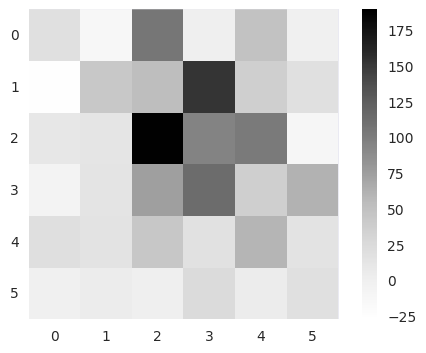

In [120]:
sns.set_style('dark')
plt.imshow(s0, origin='upper')
plt.colorbar()

In [4]:
# Make a data cube for the entire observation (and get timing)

start = Time.now()

# padding = (4, 10, 36, 0)
normal_cube = utils.get_cube(seq_files[0:10], point_sources, radius=5, normalize=False)

print("Processing time: {:.02f}".format(((Time.now() - start).sec * u.second)))

0.........Processing time: 432.50 s


In [5]:
normal_cube.shape

(28288, 10, 100)

##### Target of Interest identification

For this document we are doing a comparison to a particular target of interest (KIC 8462852 - Tabby's Star), identified below along with other point sources surrounding the target. The results displayed are from the `sextractor` output. In the full PIAA processing, all point sources act as targets of interest such that the steps below are repeated for all possible targets.

In [6]:
# Get the coordinates for the particular 
target = SkyCoord.from_name('Wasp 35')
target

<SkyCoord (ICRS): (ra, dec) in deg
    (76.08177333, -6.22982306)>

In [7]:
# Target of interest (manual lookup)
ps = point_sources.to_pandas()
ps[
    (ps['ALPHA_J2000'] >= target.ra.value - 0.1) & (ps['ALPHA_J2000'] <= target.ra.value + 0.1) & 
    (ps['DELTA_J2000'] <= target.dec.value + 0.1) & (ps['DELTA_J2000'] >= target.dec.value - 0.1)]

,MAG_BEST,MAGERR_BEST,X,Y,ALPHA_J2000,DELTA_J2000
17312,-6.8519,0.1423,2243.3284,2069.1045,76.160860,-6.202615
17381,-6.9341,0.2235,2221.1155,2078.1360,76.134289,-6.139254
17439,-8.0818,0.0634,2263.4236,2080.0142,76.129940,-6.260423
17442,-8.2141,0.0616,2269.0718,2079.7400,76.130871,-6.276587
17450,-7.5587,0.1105,2227.0498,2081.0254,76.126116,-6.156316
17479,-8.0642,0.0583,2282.3833,2082.5630,76.123072,-6.314769
17526,-9.0682,0.0256,2232.3213,2083.8430,76.118134,-6.171478
17537,-7.3173,0.1558,2245.1479,2095.0149,76.086276,-6.208481
17620,-7.7459,0.0713,2279.2349,2102.7620,76.064803,-6.306262
17639,-6.0591,0.2464,2232.5420,2109.5112,76.044214,-6.172756


#### Get Variance (Step 2-3)

We use our target star as a comparison and compare it to all other point sources in the image.

In [8]:
full_cube = normal_cube.copy()

In [9]:
# Get the variance of the target with each point source and add it to the point source table

start = Time.now()

# Get the variance
target_index = 17644 # See table above
ps['V'] = pd.Series(utils.get_all_variance(normal_cube, target_index, normalize=True))

# Sort the values by lowest total variance
ps.sort_values(by=['V'], inplace=True)

# Save values to file
ps.to_csv('vary_wasp35_{}.csv'.format(target_index))
    
print("Processing time: {:02f}".format(((Time.now() - start).value * u.second)))

Processing time: 0.000015 s


##### Display Variances

In [10]:
# Display the top five matches
ps[0:5]

,MAG_BEST,MAGERR_BEST,X,Y,ALPHA_J2000,DELTA_J2000,V
17644,-9.5013,0.0183,2252.0339,2096.4214,76.082395,-6.228229,0.000000
20783,-9.9192,0.0129,2190.0767,2458.3870,75.039114,-6.059005,0.028985
19747,-11.2456,0.0044,3302.1870,2330.5173,75.429930,-9.239331,0.039522
12456,-11.2494,0.0042,1541.9905,1494.4211,77.791473,-4.179566,0.039640
6295,-9.8794,0.0126,2720.0493,768.4941,79.928853,-7.519850,0.054014


In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots()

ax.plot(ps['V'][1000].values)
plt.xlabel('Sort Order')
plt.ylabel('V')

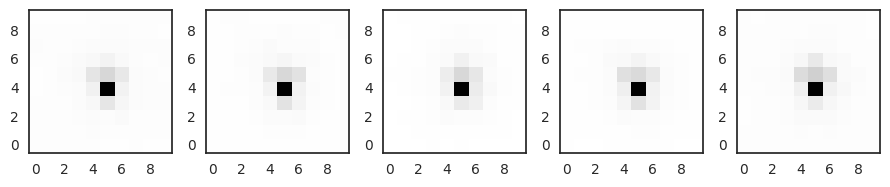

In [12]:
# Best comparisons
utils.compare_psc(normal_cube[ps.index[0:5]], w=10, h=10)

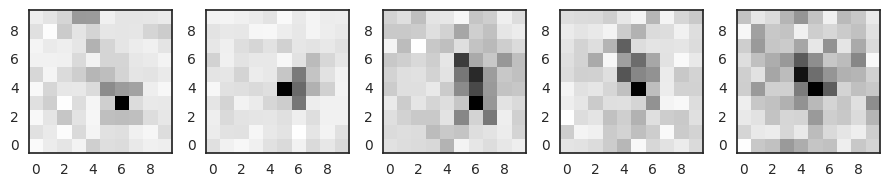

In [13]:
# Worst comparisons
utils.compare_psc(normal_cube[ps.index[-5:]], w=10, h=10)

##### Get aperture photometry

Show the first five frames for the first five best matches. This is a co-moving stamp centered around the particular point source and is used to obtain the photometry for the point source.

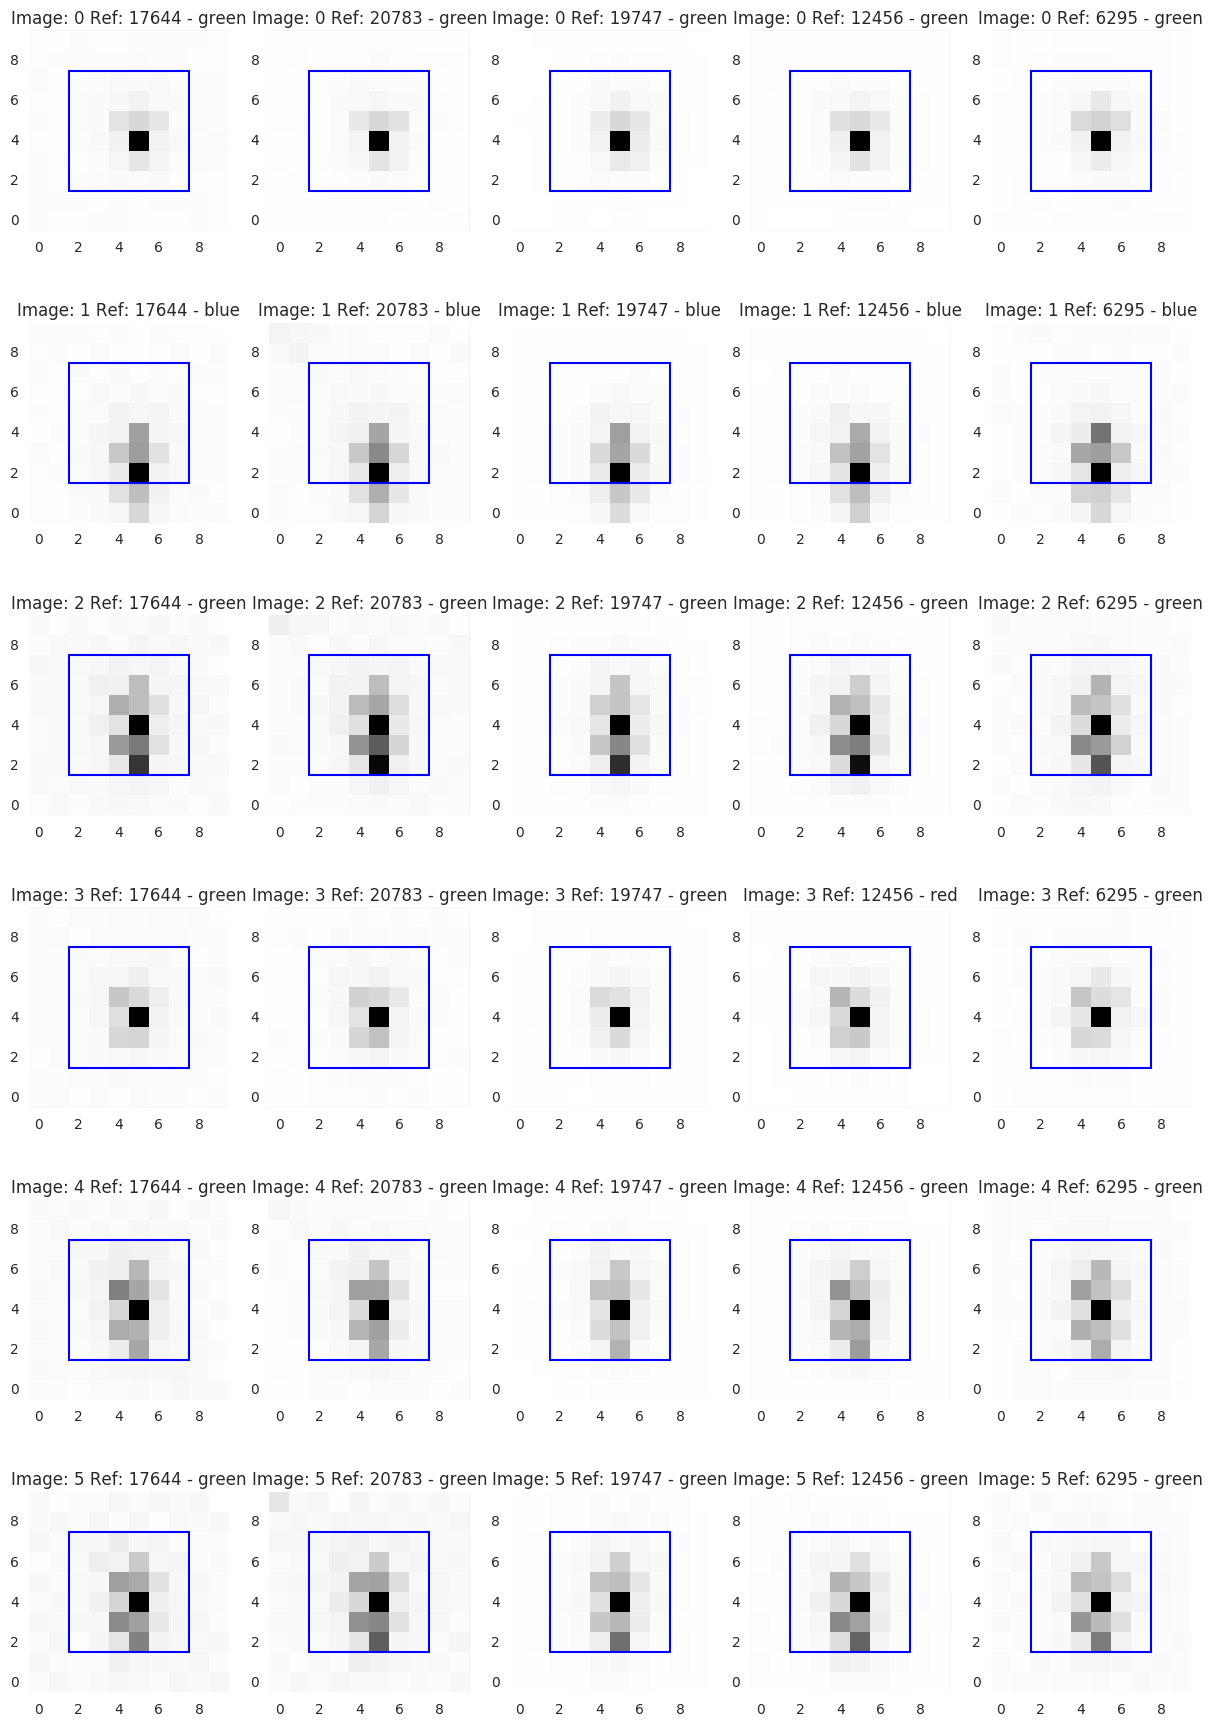

In [29]:
sns.set_style('dark')
utils.show_aperture_stamps(seq_files, ps)

### RefPSF

Construct an ideal reference PSF from the combination of the reference stamps.

**_NOTE: Under Construction Below._**

Here we are looping through each file and constructing a postage stamp around the point source in order to get the aperture flux for the source and the reference. The postage stamp and aperture corresponds to that displayed above, with a 6-square pixel aperture and a 10-square pixel overall stamp size. 

The stamp is split into individual color channels and for each color channel the background median is obtained via `astropy`'s `sigma_clipped_stats` function.

In [24]:
num_refs = 50
num_frames = 55
frame_num = 0

### Find coefficients

In [25]:
# Get the normalized reference stars
refs = np.median(normal_cube[ps[1:(num_refs+1)].index], 0)
refs.shape

(55, 100)

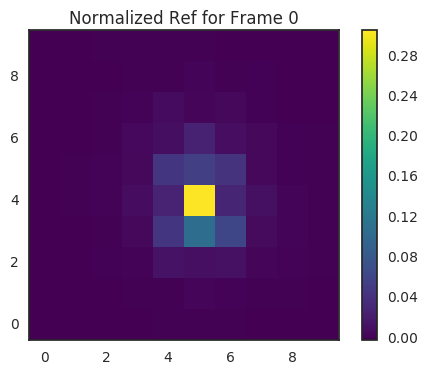

In [26]:
plt.imshow(refs[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Normalized Ref for Frame {}'.format(frame_num))

In [27]:
# Get normalized target
tar = normal_cube[ps.iloc[0].name]
tar.shape

(55, 100)

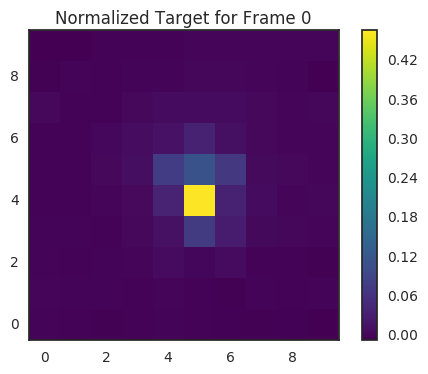

In [28]:
plt.imshow(tar[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Normalized Target for Frame {}'.format(frame_num))

In [29]:
s0 = refs[frame_num]

In [30]:
# Convert 0.0 to small number for division
s0[s0 == 0] = 1e-9

In [31]:
a0 = tar[frame_num] / refs[frame_num]
a0.shape

(100,)

In [32]:
# Fix numbers divided by zero - Should just be sigma clipping here
a0[a0 <= -1e6] = 0.
a0[a0 >= 1e6] = 0.

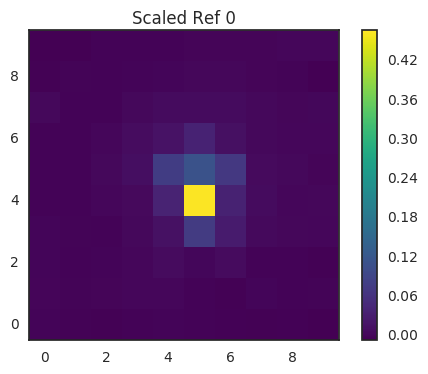

In [33]:
plt.imshow((refs[frame_num] * a0).reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Scaled Ref {}'.format(frame_num))

In [34]:
def get_ref_psf(x, B):
    # Build the matrix
    A = np.vstack([x]).T
       
    # Solve the least-squares
    p = np.linalg.lstsq(A, B)[0]
        
    return p

In [47]:
# Find the coefficients that align the reference with the target
coeff = get_ref_psf(refs.flatten(), tar.flatten())
coeff

array([ 1.10747664])

### Full Target

In [306]:
# Get the full stamps
# full_cube = utils.get_cube(seq_files[0:num_frames], point_sources, radius=5)

In [48]:
# Full target
tar_t = full_cube[ps.iloc[0].name]
tar_t.shape

(55, 100)

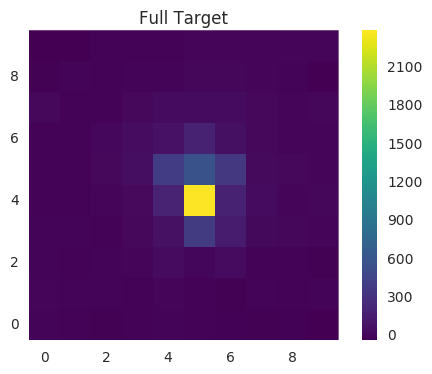

In [49]:
# Show target
sns.set_style('dark')
plt.imshow(tar_t[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Full Target')

### Construct RefPSF

In [50]:
# Get the full reference stars
b = full_cube[ps[1:(num_refs+1)].index] #.reshape(num_refs, num_frames * 100)
b.shape

(50, 55, 100)

In [63]:
refpsf = np.median(b, 0)[frame_num]

In [57]:
# Multiple the references by the coefficients
refpsf = coeff.dot(b).reshape(num_frames,100)

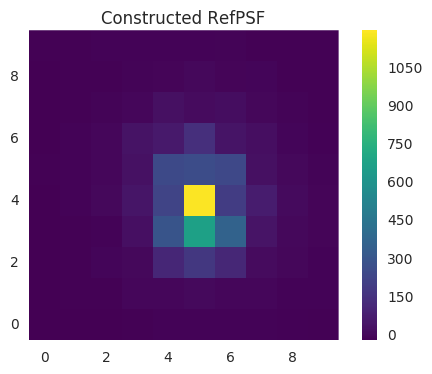

In [64]:
# Show the constructed PSF
sns.set_style('dark')
# plt.imshow(refpsf.reshape(num_frames, 10, 10)[frame_num], cmap='viridis')
# plt.imshow(refpsf[frame_num].reshape(10, 10), cmap='viridis')
plt.imshow(refpsf.reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Constructed RefPSF')

### Show Residuals

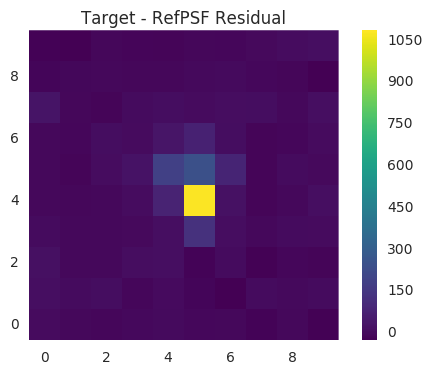

In [316]:
# Get the residuals for inspection
res = tar_t - refpsf

sns.set_style('dark')
plt.imshow(res[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Target - RefPSF Residual')

### RRC

Here we perform the Remove, Replace, and Compare step. Since we want to compare each image to the other images, we consider the set of images $A$ that we are testing to consist of only one image at a time while the set of comparison images are all other frames in the `observation`.

Then an estimate of the transit depth $a_j$ may be obtained for frame $j$ by:

$$
(1+a_j) = 
    \frac{
        \displaystyle{
                \sum_{u=-w}^{w}{ 
                    \sum_{v=-w}^{w}{
                        A_j(x_t + u, y_t + v)
                }}
        } 
    }{
        \displaystyle{
                \sum_{u=-w}^{w}{ 
                    \sum_{v=-w}^{w}{
                        \mathrm{RefPSF}_j(u, v)
                }}
        } 
    }
$$

$$(3)$$

This equation may be improved by optimal weighting of pixel values.

In [182]:
a = tar_t / refpsf

/home/wtylergee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/wtylergee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [183]:
curve = [a[i].sum() / 100 for i in range(len(a))]

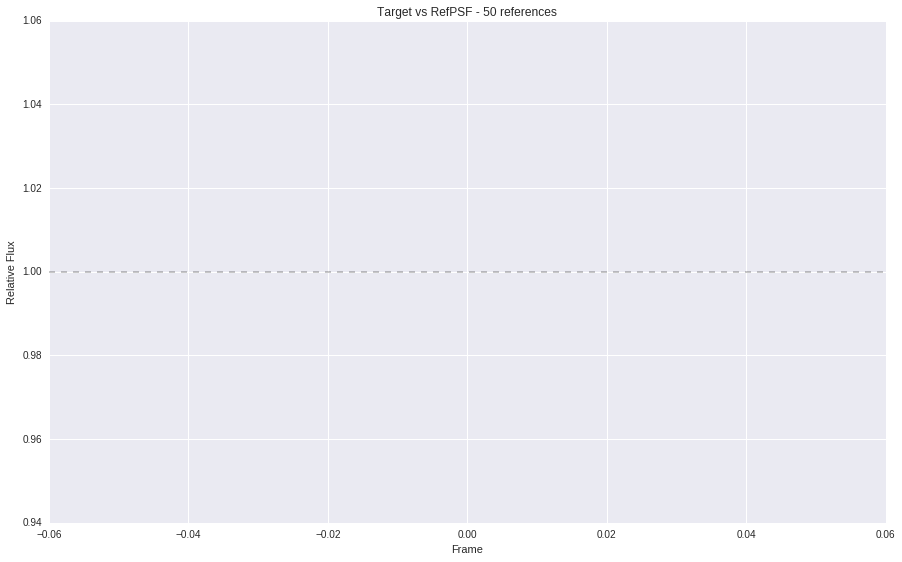

In [83]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 9))
plt.plot(curve)
plt.ylabel('Relative Flux')
plt.xlabel('Frame')
plt.title('Target vs RefPSF - {} references'.format(num_refs))
# plt.ylim(.95, 1.05)
plt.axhline(1.0, ls='--', c='k', alpha=0.25)